# Simulation For Sporadic Traffic

In [1]:
import numpy as np
import scipy.special as sp
import torch
from tqdm import tqdm_notebook
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import torch.nn as nn

In [35]:
def generate_channel_single_user(N_bs, N_ms, fc, Lp, sigma2alpha, fs, K, P_set):
    n_bs = np.expand_dims(np.arange(N_bs), axis=1)
    idx_bs = np.expand_dims(np.arange(Lp), axis=0) + np.random.randint(N_bs) + 1
    idx_bs[idx_bs > N_bs] -= N_bs
    theta_bs = idx_bs / N_bs
    A_ms = np.ones((1, Lp))
    A_bs = np.exp(-2j * np.pi * n_bs.dot(theta_bs))
    L_cp = K / 4
    tau_max = L_cp / fs
    tau = np.sort(tau_max * np.random.rand(1, Lp)) * (-2 * np.pi * fs / K)
    alpha = np.sort(np.sqrt(sigma2alpha / 2) * (np.random.randn(1, Lp) + 1j * np.random.randn(1, Lp)))
    A_r = np.fft.fft(np.eye(N_bs)) / np.sqrt(N_bs)
    A_t = np.fft.fft(np.eye(N_ms)) / np.sqrt(N_ms)
    H_frq = np.zeros((N_bs, N_ms, len(P_set)), dtype=complex)
    H_ang = np.zeros((N_bs, N_ms, len(P_set)), dtype=complex)
    for i in range(len(P_set)):
        D = np.diag((alpha * np.exp(1j * P_set[i] * tau)).squeeze())
        H_frq[:, :, i] = A_bs.dot(D).dot(A_ms.T)
        H_ang[:, :, i] = A_r.T.dot(H_frq[:, :, i]).dot(A_t)
    return H_frq, H_ang, theta_bs

In [36]:
def generate_active_user(K, Ka):
    activity = np.zeros((K, 1))
    idx = np.random.permutation(K)
    activity[idx[:Ka]] = 1
    return activity

In [37]:
def generate_active_channel(K, Ka, N_bs, P_set, Lp_min, Lp_max, N_ms, fc, sigma2alpha, fs):
    P = len(P_set)
    H_frq = np.zeros((K, N_bs, P), dtype=complex)
    H_ang = np.zeros((K, N_bs, P), dtype=complex)
    activity = generate_active_user(K, Ka)
    for user in range(K):
        Lp = np.random.randint(Lp_min, Lp_max)
        H_f, H_a, _ = generate_channel_single_user(N_bs, N_ms, fc, Lp, sigma2alpha, fs, K, P_set)
        H_frq[user] = activity[user] * np.transpose(H_f, (1, 0, 2))
        H_ang[user] = activity[user] * np.transpose(H_a, (1, 0, 2))
    return H_frq, H_ang, activity

In [38]:
def generate_batched_active_channel(params):
    H_f = np.zeros((params['simulations'], params['K'], params['N_bs'], params['P']), dtype=complex)
    H_a = np.zeros((params['simulations'], params['K'], params['N_bs'], params['P']), dtype=complex)
    act = np.zeros((params['simulations'], params['K']))
    for i in range(params['simulations']):
        H_frq, H_ang, activity = generate_active_channel(params['K'],
                                                         params['Ka'],
                                                         params['N_bs'],
                                                         params['P_set'],
                                                         params['Lp_min'],
                                                         params['Lp_max'],
                                                         params['N_ms'],
                                                         params['fc'],
                                                         params['sigma2alpha'],
                                                         params['fs'])
        H_f[i] = H_frq
        H_a[i] = H_ang
        act[i] = activity.squeeze()
    return H_f, H_a, act

In [39]:
def generate_random_pilot(T, K, P, batch):
    pilot = (np.random.randn(batch, T, K, P) + 1j * np.random.randn(batch, T, K, P)) / np.sqrt(2)
    return pilot

In [40]:
def pilot_through_channel(pilot, H_f, nvar):
    batch_size, K, N_bs, P = H_f.shape
    _, T, _, _ = pilot.shape
    y = np.zeros((batch_size, T, N_bs, P), dtype=complex)
    for sim in range(batch_size):
        for p in range(P):
            noise = np.sqrt(nvar / 2) * (np.random.randn(T, N_bs) + 1j * np.random.randn(T, N_bs))
            y[sim, :, :, p] = pilot[sim, :, :, p].dot(H_f[sim, :, :, p]) + noise
    return y

In [41]:
def dmmv_amp_detection(y, pilot):
    iters = 200
    tol = 1e-5
    snr0 = 100
    damp = 0.3
    batch_size, G, M, P = y.shape
    _, _, K, _ = pilot.shape
    d = G / K
    normal_cdf = lambda x: 0.5 * (1 + sp.erf(x / np.sqrt(2)))
    normal_pdf = lambda x: np.exp(-x ** 2 / 2) / np.sqrt(2 * np.pi)
    alpha_grid = np.linspace(0, 10, 1024)
    rho_se = (1 - (2 / d) * ((1 + alpha_grid ** 2) * normal_cdf(-alpha_grid) - alpha_grid * normal_pdf(alpha_grid))) /\
        (1 + alpha_grid ** 2 - 2 * ((1 + alpha_grid ** 2) * normal_cdf(-alpha_grid) - alpha_grid * normal_pdf(alpha_grid)))
    rho_se = np.max(rho_se)
    xhat = np.zeros((batch_size, K, M, P), dtype=complex)
    lamda = rho_se * d * np.ones((batch_size, K, M, P))
    iteration = np.zeros((batch_size))
    NMSE_watch = np.zeros((batch_size, iters))
    for sim in tqdm_notebook(range(batch_size), desc='simulation'):
        xmean = 0
        xvar = 0
        nvar = np.zeros(P)
        for p in range(P):
            for t in range(M):
                nvar[p] += np.linalg.norm(y[sim, :, t, p]) ** 2 / ((1 + snr0) * G)
                xvar += (np.linalg.norm(y[sim, :, t, p]) ** 2 - G * nvar[p]) / (rho_se * d * np.linalg.norm(pilot[sim, :, :, p], ord='fro') ** 2)
        xvar = xvar / M / P
        nvar = nvar / M
        v = np.ones((K, M, P)) * xvar
        V = np.ones((G, M, P))
        Z = y[sim].copy()
        S = np.zeros((K, M, P))
        R = np.zeros((K, M, P), dtype=complex)
        m = np.zeros((K, M, P), dtype=complex)
        L = np.zeros((K, M, P))
        Vrs = np.zeros((K, M, P))
        for it in range(iters):
            x_pre = xhat[sim].copy()
            for p in range(P):
                V_new = (np.abs(pilot[sim, :, :, p]) ** 2).dot(v[:, :, p])
                Z_new = pilot[sim, :, :, p].dot(xhat[sim, :, :, p]) - (y[sim, :, :, p] - Z[:, :, p]) / (nvar[p] + V[:, :, p]) * V_new
                V[:, :, p] = damp * V[:, :, p] + (1 - damp) * V_new
                Z[:, :, p] = damp * Z[:, :, p] + (1 - damp) * Z_new
                S[:, :, p] = 1 / (np.abs(pilot[sim, :, :, p]) ** 2).T.dot(1 / (nvar[p] + V[:, :, p]))
                R[:, :, p] = (np.conj(pilot[sim, :, :, p]).T.dot((y[sim, :, :, p] - Z[:, :, p]) / (nvar[p] + V[:, :, p]))) * S[:, :, p] + xhat[sim, :, :, p]
                L[:, :, p] = 0.5 * (np.log(S[:, :, p] / (S[:, :, p] + xvar)) + np.abs(R[:, :, p]) ** 2 / S[:, :, p] - (np.abs(R[:, :, p] - xmean)) ** 2 / (S[:, :, p] + xvar))
                lamda[sim, :, :, p] /= lamda[sim, :, :, p] + (1 - lamda[sim, :, :, p]) * np.exp(-L[:, :, p])
                m[:, :, p] = (xvar * R[:, :, p] + xmean * S[:, :, p]) / (S[:, :, p] + xvar)
                Vrs[:, :, p] = xvar * S[:, :, p] / (xvar + S[:, :, p])
                xhat[sim, :, :, p] = lamda[sim, :, :, p] * m[:, :, p]
                v[:, :, p] = lamda[sim, :, :, p] * (np.abs(m[:, :, p]) ** 2 + Vrs[:, :, p]) - np.abs(xhat[sim, :, :, p]) ** 2
                nvar[p] = np.sum(np.abs(y[sim, :, :, p] - Z[:, :, p]) ** 2 / np.abs(1 + V[:, :, p] / nvar[p]) ** 2 + V[:, :, p] / (1 + V[:, :, p] / nvar[p])) / (G * M)
            xmean = np.sum(lamda[sim] * m) / np.sum(lamda[sim])
            xvar = np.sum(lamda[sim] * (np.abs(xmean - m) ** 2 + Vrs)) / np.sum(lamda[sim])
            
            if P == 1:
                pi = lamda[sim]
                pi_update = np.sum(pi, axis=1) / M
                for k in range(K):
                    lamda[sim, k] = pi_update[k]
            else:
                pi = np.transpose(lamda[sim], (1, 2, 0))
                pi_update = np.sum(pi) / (M * P)
                for k in range(K):
                    lamda[sim, k] = pi_update[k]
            
            NMSE_watch[sim, it] = np.linalg.norm(x_pre - xhat[sim]) / np.linalg.norm(xhat[sim])
            if NMSE_watch[sim, it] < tol:
                iteration[sim] = it
                break
    return xhat, lamda, iteration, NMSE_watch

In [42]:
def lamda_aud(lamda, N_bs):
    batch_size, K, M, P = lamda.shape
    act_lam = np.zeros((batch_size, K))
    act_lam[np.sum(lamda > 0.5, axis=(2, 3)) > 0.9 * N_bs * P] = 1
    return act_lam

def channel_aud(H, N_bs):
    batch_size, K, M, P = H.shape
    act_ch = np.zeros((batch_size, K))
    p_th = np.max(np.abs(H), axis=(1, 2, 3), keepdims=True) * 0.01
    act_ch[np.sum((np.abs(H) > p_th), axis=(2, 3)) > 0.9 * N_bs * P] = 1
    return act_ch

def performance(det_act, true_act, det_H, true_H):
    _, K = det_act.shape
    Pe = np.mean(np.sum(np.abs(det_act - true_act), axis=1) / K)
    FA = np.mean(np.sum((det_act - true_act) == 1, axis=1) / K)
    PM = np.mean(np.sum((det_act - true_act) == -1, axis=1) / K)
    NMSE = np.linalg.norm(det_H - true_H) ** 2 / np.linalg.norm(true_H) ** 2
    return Pe, FA, PM, NMSE

Hyper Parameters

In [81]:
params = {
    'K': 500, # number of potential users
    'Ka': 100, # number of active users
    'N_bs': 64, # number of receiver antennas
    'N_ms': 1, # number of user antennas
    'fc': 2e9, # frequency of carrier
    'sigma2alpha': 1, # average power of path
    'Bw': 1e7, # bandwidth
    'fs': 1e7, # frequency of sampling
    'N': 2048, # number of carriers
    'P': 1, # length of pilot
    'Lp_min': 8, # min number of pathes
    'Lp_max': 14, # max number of pathes
    'snr': 20, # SNR in dB
    'simulations': 300, # total simulation numbers
    'T_set': np.arange(30, 82, 2), # choices for time overhead
    'Ka_set': np.arange(30, 155, 5), # choices for number of active users
    'LR': 0.001, # learning rate
    'EPOCH': 300, # training epochs
    'T': 30, # time overhead
}
delta_p = np.floor(params['N'] / params['P']).astype(int)
P_set = np.linspace(delta_p, params['P'] * delta_p, params['P'])
params.update({'P_set':  P_set})
nvar = 10 ** (-params['snr'] / 10)
params.update({'nvar': nvar})

In [65]:
Pe_p = np.zeros(params['T_set'].shape)
FA_p = np.zeros(params['T_set'].shape)
FM_p = np.zeros(params['T_set'].shape)
NMSE = np.zeros(params['T_set'].shape)
Pe_h = np.zeros(params['T_set'].shape)
FA_h = np.zeros(params['T_set'].shape)
FM_h = np.zeros(params['T_set'].shape)
for i, T in enumerate(params['T_set']):
    H_f, H_a, activity = generate_batched_active_channel(params)
    pilot = generate_random_pilot(T, params['K'], params['P'], params['simulations'])
    y = pilot_through_channel(pilot, H_f, params['nvar'])
    
    xhat, lamda, iteration, NMSE_watch = dmmv_amp_detection(y, pilot)
    
    act_lam = lamda_aud(lamda, params['N_bs'])
    act_ch = channel_aud(xhat, params['N_bs'])
    Pe_p[i], FA_p[i], FM_p[i], NMSE[i] = performance(act_lam, activity, xhat, H_f)
    Pe_h[i], FA_h[i], FM_h[i], _ = performance(act_ch, activity, xhat, H_f)


C:\Users\Cbx\Anaconda3\envs\EE369\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


In [83]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

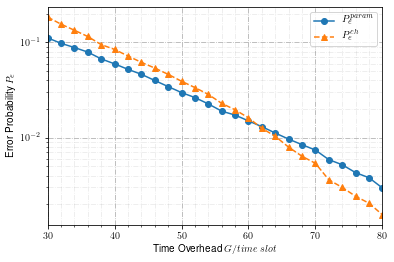

In [69]:
plt.semilogy(params['T_set'], Pe_p, '-o')
plt.semilogy(params['T_set'], Pe_h, '--^')
plt.xlim([30, 80])
plt.grid(True, linestyle='-.')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-.', alpha=0.2)
plt.legend(['$P_e^{param}$', '$P_e^{ch}$'])
plt.xlabel('Time Overhead $G/time\ slot$')
plt.ylabel('Error Probability $P_e$')
plt.savefig(fname='Probability_of_errorKa100.pdf')
plt.show()

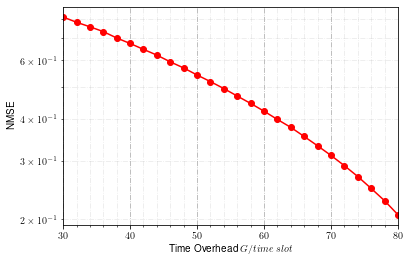

In [67]:
plt.semilogy(params['T_set'], NMSE, 'r-o')
plt.xlim([30, 80])
plt.grid(which='major', linestyle='-.')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-.', alpha=0.2)
plt.xlabel('Time Overhead $G/time\ slot$')
plt.ylabel('NMSE')
plt.savefig(fname='NMSEKa100.pdf')
plt.show()

In [68]:
np.savez('K500Ka100NBS64SNR20sim300AMP.npz', Pe_p, FM_p, FA_p, Pe_h, FM_h, FA_h, NMSE)

In [71]:
Pe_p = np.zeros(params['Ka_set'].shape)
FA_p = np.zeros(params['Ka_set'].shape)
FM_p = np.zeros(params['Ka_set'].shape)
NMSE = np.zeros(params['Ka_set'].shape)
Pe_h = np.zeros(params['Ka_set'].shape)
FA_h = np.zeros(params['Ka_set'].shape)
FM_h = np.zeros(params['Ka_set'].shape)
for i, Ka in enumerate(params['Ka_set']):
    params['Ka'] = Ka
    H_f, H_a, activity = generate_batched_active_channel(params)
    pilot = generate_random_pilot(50, params['K'], params['P'], params['simulations'])
    y = pilot_through_channel(pilot, H_f, params['nvar'])
    
    xhat, lamda, iteration, NMSE_watch = dmmv_amp_detection(y, pilot)
    
    act_lam = lamda_aud(lamda, params['N_bs'])
    act_ch = channel_aud(xhat, params['N_bs'])
    Pe_p[i], FA_p[i], FM_p[i], NMSE[i] = performance(act_lam, activity, xhat, H_f)
    Pe_h[i], FA_h[i], FM_h[i], _ = performance(act_ch, activity, xhat, H_f)

C:\Users\Cbx\Anaconda3\envs\EE369\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


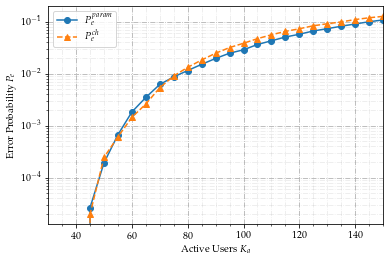

In [84]:
plt.semilogy(params['Ka_set'], Pe_p, '-o')
plt.semilogy(params['Ka_set'], Pe_h, '--^')
plt.xlim([30, 150])
plt.grid(True, linestyle='-.')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-.', alpha=0.2)
plt.legend(['$P_e^{param}$', '$P_e^{ch}$'])
plt.xlabel('Active Users $K_a$')
plt.ylabel('Error Probability $P_e$')
plt.savefig(fname='Probability_of_errorT50.pdf')
plt.show()

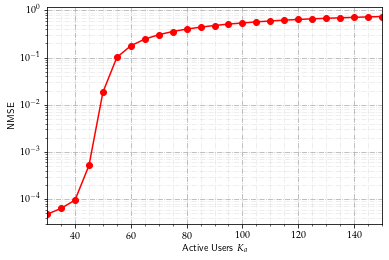

In [81]:
plt.semilogy(params['Ka_set'], NMSE, 'r-o')
plt.xlim([30, 150])
plt.grid(which='major', linestyle='-.')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-.', alpha=0.2)
plt.xlabel('Active Users $K_a$')
plt.ylabel('NMSE')
plt.savefig(fname='NMSET50.pdf')
plt.show()

In [79]:
np.savez('K500T50NBS64SNR20sim300AMP.npz', Pe_p, FM_p, FA_p, Pe_h, FM_h, FA_h, NMSE)

In [100]:
class ComplexLinear(nn.Module):
    def __init__(self, M, N, activation=None):
        super(ComplexLinear, self).__init__()
        self.real = nn.Linear(M // 2, N // 2)
        self.imag = nn.Linear(M // 2, N // 2)
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = None
    
    def forward(self, x):
        x_real = x[:, :x.shape[1] // 2]
        x_imag = x[:, x.shape[1] // 2:]
        real_real = self.real(x_real)
        real_imag = self.real(x_imag)
        imag_real = self.imag(x_real)
        imag_imag = self.imag(x_imag)
        real_y = real_real - imag_imag
        imag_y = real_imag + imag_real
        y = torch.cat((real_y, imag_y), dim=1)
        if self.activation != None:
            y = self.activation(y)
        return y
    

def complexmatmul(X, Y):
    X_real = X[:, :X.shape[1] // 2, :]
    X_imag = X[:, X.shape[1] // 2:, :]
    Y_real = Y[:, :Y.shape[1] // 2, :].permute(0, 2, 1)
    Y_imag = Y[:, Y.shape[1] // 2:, :].permute(0, 2, 1)
    res_real = Y_real.matmul(X_real) - Y_imag.matmul(X_imag)
    res_imag = Y_real.matmul(X_imag) + Y_imag.matmul(X_real)
    res = torch.cat((res_real, res_imag), dim=1)
    return res


class SimpleResNet(nn.Module):
    def __init__(self, N_bs, T, K):
        super(SimpleResNet, self).__init__()
        self.inputsize = 2 * N_bs * T
        self.outputsize = 2 * N_bs * K
        self.N_bs = N_bs
        self.T = T
        self.K = K
        self.block1 = ComplexLinear(self.inputsize, self.inputsize)
        self.block2 = ComplexLinear(self.inputsize, self.inputsize)
        self.block3 = nn.Sequential(
            ComplexLinear(self.outputsize, 1000),
            ComplexLinear(1000, self.outputsize),
        )
        # self.block4 = ComplexLinear(self.outputsize, self.outputsize)
        
    def forward(self, Y, P):
        Y = Y.view(Y.shape[0], -1)
        Y1 = self.block1(Y)
        Y1 = Y + Y1
        Y2 = self.block2(Y1)
        Y2 = Y1 + Y2
        Y2 = Y2.reshape(Y2.shape[0], 2 * self.T, -1)
        X = complexmatmul(Y2, P)
        X = X.view(X.shape[0], -1)
        X1 = self.block3(X)
        X = X + X1
        # X2 = self.block4(X1)
        # X2 = X2 + X1
        # X2 = X2.reshape(X2.shape[0], 2 * self.N_bs, -1)
        X = X.reshape(X.shape[0], 2 * self.K, -1)
        return X

In [90]:
def totensor(x, cuda=False):
    x_real = torch.from_numpy(np.real(x)).squeeze().float()
    x_imag = torch.from_numpy(np.imag(x)).squeeze().float()
    if cuda:
        X_train = torch.cat((x_real, x_imag), dim=1).cuda()
    else:
        X_train = torch.cat((x_real, x_imag), dim=1)
    return X_train


def toarray(x, cuda=False):
    x = x.detach()
    if cuda:
        x = x.cpu()
    x = x.numpy()
    x = x[:, :x.shape[1] // 2] + x[:, x.shape[1] // 2:] * 1j
    return x

In [113]:
H_f_train, H_a_train, activity_train = generate_batched_active_channel(params)
pilot_train = generate_random_pilot(30, params['K'], params['P'], params['simulations'])
y_train = pilot_through_channel(pilot, H_f, params['nvar'])
P_train = totensor(pilot_train, cuda=True)
Y_train = totensor(y_train, cuda=True)
H_train = totensor(H_f_train, cuda=True)

In [114]:
H_f_test, H_a_test, activity_test = generate_batched_active_channel(params)
pilot_test = generate_random_pilot(30, params['K'], params['P'], 100)
y_test = pilot_through_channel(pilot, H_f, params['nvar'])
P_test = totensor(pilot_train, cuda=True)
Y_test = totensor(y_train, cuda=True)
H_test = totensor(H_f_train, cuda=True)

In [115]:
net = SimpleResNet(params['N_bs'], 30, params['K']).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=params['LR'])
loss_func = nn.MSELoss()
losses_train = np.zeros((params['EPOCH']))
losses_test = np.zeros((params['EPOCH']))
for epoch in tqdm_notebook(range(params['EPOCH'])):
    channel = net(Y_train, P_train)
    loss = loss_func(channel, H_train)
    losses_train[epoch] = loss.cpu().item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    channel_test = net(Y_test, P_test)
    loss_test = loss_func(channel_test, H_test)
    losses_test[epoch] = loss_test.cpu().item()

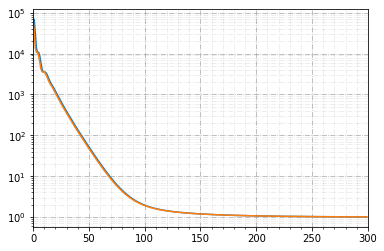

In [108]:
plt.semilogy(losses_train)
plt.semilogy(losses_test)
plt.xlim([0, 300])
plt.grid(which='major', linestyle='-.')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-.', alpha=0.2)

In [116]:
del P_train, Y_train, H_train, P_test, Y_test, H_test

In [119]:
Pe_n = np.zeros(params['Ka_set'].shape)
FA_n = np.zeros(params['Ka_set'].shape)
FM_n = np.zeros(params['Ka_set'].shape)
NMSE_n = np.zeros(params['Ka_set'].shape)

for i, Ka in enumerate(tqdm_notebook(params['Ka_set'])):
    params['Ka'] = Ka
    H_f, H_a, activity = generate_batched_active_channel(params)
    pilot = generate_random_pilot(50, params['K'], params['P'], params['simulations'])
    y = pilot_through_channel(pilot, H_f, params['nvar'])
    
    P_test = totensor(pilot_train, cuda=True)
    Y_test = totensor(y_train, cuda=True)
    H_test = totensor(H_f_train, cuda=True)
    
    channel = net(Y_test, P_test)

    hf = toarray(channel, cuda=True)
    hf = np.expand_dims(hf, axis=3)
    act_ch = channel_aud(hf, params['N_bs'])
    Pe_n[i], FA_n[i], FM_n[i], NMSE_n[i] = performance(act_ch, activity, hf, H_f)

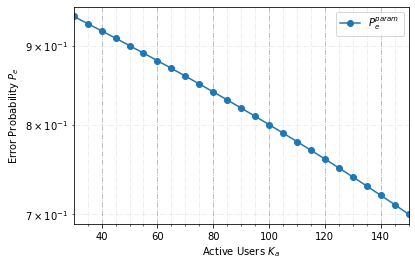

In [120]:
plt.semilogy(params['Ka_set'], Pe_n, '-o')
plt.xlim([30, 150])
plt.grid(True, linestyle='-.')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-.', alpha=0.2)
plt.legend(['$P_e^{param}$', '$P_e^{ch}$'])
plt.xlabel('Active Users $K_a$')
plt.ylabel('Error Probability $P_e$')
plt.savefig(fname='Probability_of_errorT30NN.pdf')
plt.show()

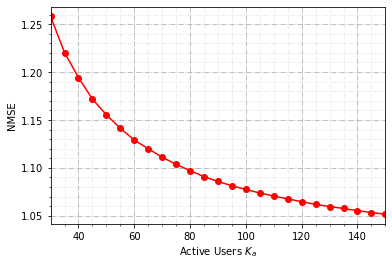

In [124]:
plt.plot(params['Ka_set'], NMSE_n, 'r-o')
plt.xlim([30, 150])
plt.grid(which='major', linestyle='-.')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-.', alpha=0.2)
plt.xlabel('Active Users $K_a$')
plt.ylabel('NMSE')
plt.savefig(fname='NMSET30NN.pdf')
plt.show()